In [25]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans

from tqdm.notebook import tqdm 

from torch.utils.tensorboard import SummaryWriter

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim.lr_scheduler as lr_scheduler

from models.baseline import BaseLineModel
from ddpm.ddpm import GaussianDiffusion1D
from evaluation.evaluation import vizual_comparison, plot_jsd_per_customer, plot_kde_samples, make_gif_from_images

# Params

In [ ]:
## Data
seq_len = 12
batch_size = 256
k = 15

#NN
device = 'cuda' if torch.cuda.is_available() else 'cpu'
latent_dim = 1000
cond_model = "mlp"
num_layers = 6
n_heads = 4
lr = 5*16**-4
decay_rate = 0.9
epochs = 3000
save_rate = 100

## DDPM
timesteps = 1000
beta_schedule = "linear"
objective = "pred_noise"

## Logging
experiment_name = "base_5kepoch_kmeans15_customer_seq12"
logging_dir = f"./logging/{experiment_name}/"

In [3]:
if not os.path.isdir(logging_dir):
    os.makedirs(logging_dir)
    os.makedirs(os.path.join(logging_dir, "viz/"))
    os.makedirs(os.path.join(logging_dir, "jsd/"))
    os.makedirs(os.path.join(logging_dir, "kde/"))
    os.makedirs(os.path.join(logging_dir, "tensorboard/"))
    os.makedirs(os.path.join(logging_dir, "weights/"))
    os.makedirs(os.path.join(logging_dir, "ts_sample/"))

# Utils

In [4]:
PREPROCESSED_DIR = "./preprocessing/data/customer_led_network_revolution/preprocessed/"

In [5]:
class MakeDATA(Dataset):
    def __init__(self, data, seq_len):
        data = np.asarray(data, dtype=np.float32)
        seq_data = []
        for i in range(len(data) - seq_len + 1):
            x = data[i : i + seq_len]
            seq_data.append(x)
        self.samples = np.asarray(seq_data, dtype=np.float32) 

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

In [6]:
def cluster(data, k):
    kmeans = KMeans(n_clusters=k)
    cluster_labels = kmeans.fit_predict(data.T)
    
    clustered_data = []
    for cluster in range(kmeans.n_clusters):
        cluster_data = data.iloc[:, cluster_labels == cluster].mean(axis=1)
        clustered_data.append(cluster_data)
        
    return pd.DataFrame(clustered_data).T

# Load Data

In [7]:
train = pd.read_csv(os.path.join(PREPROCESSED_DIR, "train.csv"))
val = pd.read_csv(os.path.join(PREPROCESSED_DIR, "val.csv"))
test = pd.read_csv(os.path.join(PREPROCESSED_DIR, "test.csv"))
cond_train = pd.read_csv(os.path.join(PREPROCESSED_DIR, "cond_train.csv"))
cond_val = pd.read_csv(os.path.join(PREPROCESSED_DIR, "cond_val.csv"))
cond_test = pd.read_csv(os.path.join(PREPROCESSED_DIR, "cond_test.csv"))

In [8]:
train.drop("Date and Time of capture", axis=1, inplace=True)
val.drop("Date and Time of capture", axis=1, inplace=True)
test.drop("Date and Time of capture", axis=1, inplace=True)

In [9]:
train = cluster(train, k)
test = cluster(test, k)
val = cluster(val, k)

c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [10]:
train.shape, val.shape, test.shape, cond_train.shape, cond_val.shape, cond_test.shape

((33984, 15), (6796, 15), (1700, 15), (33984, 27), (6796, 27), (1700, 27))

In [11]:
train_seq = np.asarray(MakeDATA(train, seq_len)).transpose(0, 2, 1)
cond_train_seq = np.asarray(MakeDATA(cond_train, seq_len)).transpose(0, 2, 1)

val_seq = np.asarray(MakeDATA(val, seq_len)).transpose(0, 2, 1)
cond_val_seq = np.asarray(MakeDATA(cond_val, seq_len)).transpose(0, 2, 1)

test_seq = np.asarray(MakeDATA(test, seq_len)).transpose(0, 2, 1)
cond_test_seq = np.asarray(MakeDATA(cond_test, seq_len)).transpose(0, 2, 1)

train_seq.shape, cond_train_seq.shape, test_seq.shape, cond_test_seq.shape

((33973, 15, 12), (33973, 27, 12), (1689, 15, 12), (1689, 27, 12))

In [12]:
train_dataset = TensorDataset(torch.from_numpy(train_seq), torch.from_numpy(cond_train_seq))
train_loader = DataLoader(train_dataset, batch_size, shuffle=False)

val_dataset = TensorDataset(torch.from_numpy(val_seq), torch.from_numpy(cond_val_seq))
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)

test_dataset = TensorDataset(torch.from_numpy(test_seq), torch.from_numpy(cond_test_seq))
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

In [13]:
real_data_val, real_cond_data_val = next(iter(val_loader))

# Load Model

In [14]:
model = BaseLineModel(seq_len=seq_len, hidden_dim=latent_dim, cond_dim=cond_train_seq.shape[1], cond_model=cond_model, device=device, channels=train_seq.shape[1])

ddpm = GaussianDiffusion1D(model, seq_length = seq_len, timesteps = timesteps, objective = objective, loss_type = 'l2', beta_schedule = beta_schedule)
ddpm = ddpm.to(device)

optim = torch.optim.Adam(ddpm.parameters(), lr = lr)
scheduler = lr_scheduler.StepLR(optim, step_size=1000, gamma=0.9)

writer = SummaryWriter(os.path.join(logging_dir, "tensorboard/"))

# Train

In [15]:
#taken from https://medium.com/@heyamit10/exponential-moving-average-ema-in-pytorch-eb8b6f1718eb
class EMA:
    def __init__(self, model, decay):
        """
        Initialize EMA class to manage exponential moving average of model parameters.
        
        Args:
            model (torch.nn.Module): The model for which EMA will track parameters.
            decay (float): Decay rate, typically a value close to 1, e.g., 0.999.
        """
        self.model = model
        self.decay = decay
        self.shadow = {}
        self.backup = {}

        # Store initial parameters
        for name, param in model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def update(self):
        """
        Update shadow parameters with exponential decay.
        """
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                new_average = (1.0 - self.decay) * param.data + self.decay * self.shadow[name]
                self.shadow[name] = new_average.clone()

    def apply_shadow(self):
        """
        Apply shadow (EMA) parameters to model.
        """
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.backup[name] = param.data.clone()
                param.data = self.shadow[name]

    def restore(self):
        """
        Restore original model parameters from backup.
        """
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                param.data = self.backup[name]

In [16]:
def save_model(model_dict, ema_shadow, optimizer_dict, filepath):
    checkpoint = {
        'model_state_dict': model_dict,
        'ema_state_dict': ema_shadow,
        'optimizer_state_dict': optimizer_dict,
    }
    torch.save(checkpoint, filepath)

In [17]:
def load_checkpoint(model, ema, optimizer, filepath):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    if 'ema_state_dict' in checkpoint:
        for name, param in model.named_parameters():
            if param.requires_grad and name in checkpoint['ema_state_dict']:
                ema.shadow[name] = checkpoint['ema_state_dict'][name].clone()
    
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [18]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.
    
    for i, (data, cond_data) in enumerate(train_loader):
        data = data.to(device)
        
        cond_data = cond_data.float()
        cond_data = cond_data.to(device)
        
        optim.zero_grad()
        
        loss = ddpm(data, cond_data)
        loss.backward()
        
        optim.step()
        ema.update()
        
        running_loss += loss.item()
        
        if i % 100 == 0:
            last_loss = running_loss / 1000 # loss per batch
            tb_x = epoch_index * len(train_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.
    return last_loss

In [19]:
epoch_number = 0
best_val_loss = 1_000_000.
snapshots = {}
save_dir =  os.path.join(logging_dir, "weights/")

ema = EMA(model, decay=decay_rate)

for epoch in tqdm(range(1, epochs+1)):
    print('epoch {}:'.format(epoch_number + 1))
    
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)
    
    running_val_loss = 0.0
    
    ema.apply_shadow()
    model.eval()
    with torch.no_grad():
        for i, (val_data, val_cond) in enumerate(val_loader):
            val_data = val_data.to(device)
        
            val_cond = val_cond.float()
            val_cond = val_cond.to(device)
            val_loss = ddpm(val_data, val_cond)
            
            running_val_loss += val_loss
    
    avg_val_loss = running_val_loss / (i + 1)
    print('Loss train {} val {}'.format(avg_loss, avg_val_loss))
    
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_val_loss },
                    epoch_number + 1)
    
    ema.restore()
    
    writer.flush()
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_dict = model.state_dict()
        best_model_opt = optim.state_dict()
        best_model_shadow = ema.shadow
        
    
    if epoch_number % save_rate == 0:
        generated_sample = ddpm.sample(batch_size, real_cond_data_val.to(device))
        generated_sample = generated_sample.cpu().numpy()
        snapshots[epoch_number] = generated_sample
        
        model_name = f"model_epoch_{epoch_number}_val_{avg_val_loss:.4f}.pth"
        save_model(model.state_dict(), ema.shadow, optim.state_dict(), os.path.join(save_dir, model_name))
    
    epoch_number += 1

  0%|          | 0/10 [00:00<?, ?it/s]

epoch 1:


c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\torch\nn\modules\rnn.py:1123: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:1410.)
  result = _VF.lstm(


Loss train 1.9580514006614684 val 5.797123908996582


sampling loop time step: 100%|██████████| 1000/1000 [00:10<00:00, 94.81it/s]


epoch 2:
Loss train 0.6020283772945404 val 18.394107818603516
epoch 3:
Loss train 1.6322246623039245 val 17.877613067626953


sampling loop time step: 100%|██████████| 1000/1000 [00:10<00:00, 93.81it/s]


epoch 4:
Loss train 12.291459511995315 val 21.382081985473633
epoch 5:
Loss train 0.5003260012865066 val 20.352771759033203


sampling loop time step: 100%|██████████| 1000/1000 [00:10<00:00, 93.07it/s]


epoch 6:
Loss train 1.293536653637886 val 19.926496505737305
epoch 7:
Loss train 0.4126895580291748 val 18.646469116210938


sampling loop time step: 100%|██████████| 1000/1000 [00:10<00:00, 92.48it/s]


epoch 8:
Loss train 10.065424760818482 val 19.091978073120117
epoch 9:
Loss train 0.3868104602098465 val 18.133047103881836


sampling loop time step: 100%|██████████| 1000/1000 [00:10<00:00, 92.40it/s]


epoch 10:
Loss train 0.45502681040763854 val 16.782869338989258


In [22]:
save_model(best_model_dict, best_model_shadow, best_model_opt, os.path.join(logging_dir, "weights/", "best_model.pth"))

In [23]:
load_checkpoint(model, ema, optim, os.path.join(logging_dir, "weights/", "best_model.pth"))

C:\Users\Arne\AppData\Local\Temp\ipykernel_25804\3801699692.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filepath)


In [26]:
for k, v in snapshots.items():
    plot_kde_samples(v, real_data_val,show=False, fpath=os.path.join(logging_dir, "kde/", f"kde_epoch_{k}.png"), epoch=k)
    
paths = []
for kde_plot in os.listdir(os.path.join(logging_dir, "kde/")):
    paths.append(os.path.join(logging_dir, "kde/", kde_plot))

make_gif_from_images(paths, os.path.join(logging_dir, "kde/", "kde_progression.gif"))

# Evaluation

In [27]:
real_data_test, real_cond_data_test = next(iter(test_loader))

In [28]:
with torch.no_grad():
    samples = ddpm.sample(batch_size, real_cond_data_test.to(device))
    samples = samples.cpu().numpy()

print(f"Samples shape: {samples.shape}")

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\torch\nn\modules\rnn.py:1123: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:1410.)
  result = _VF.lstm(
sampling loop time step: 100%|██████████| 1000/1000 [00:10<00:00, 92.77it/s]


Samples shape: (256, 15, 12)


c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


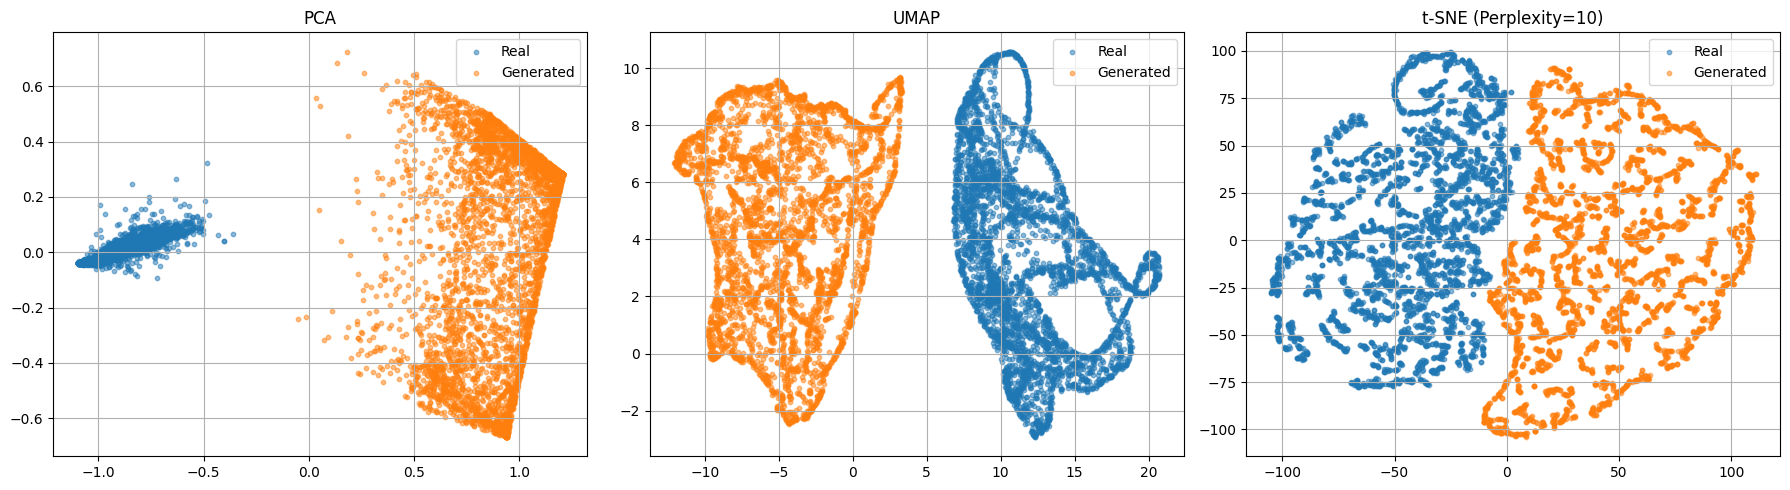

In [29]:
vizual_comparison(samples, real_data_test, os.path.join(logging_dir, "viz/", "pca_umap_tsne_all_batches.png"), use_all_data=True);

c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


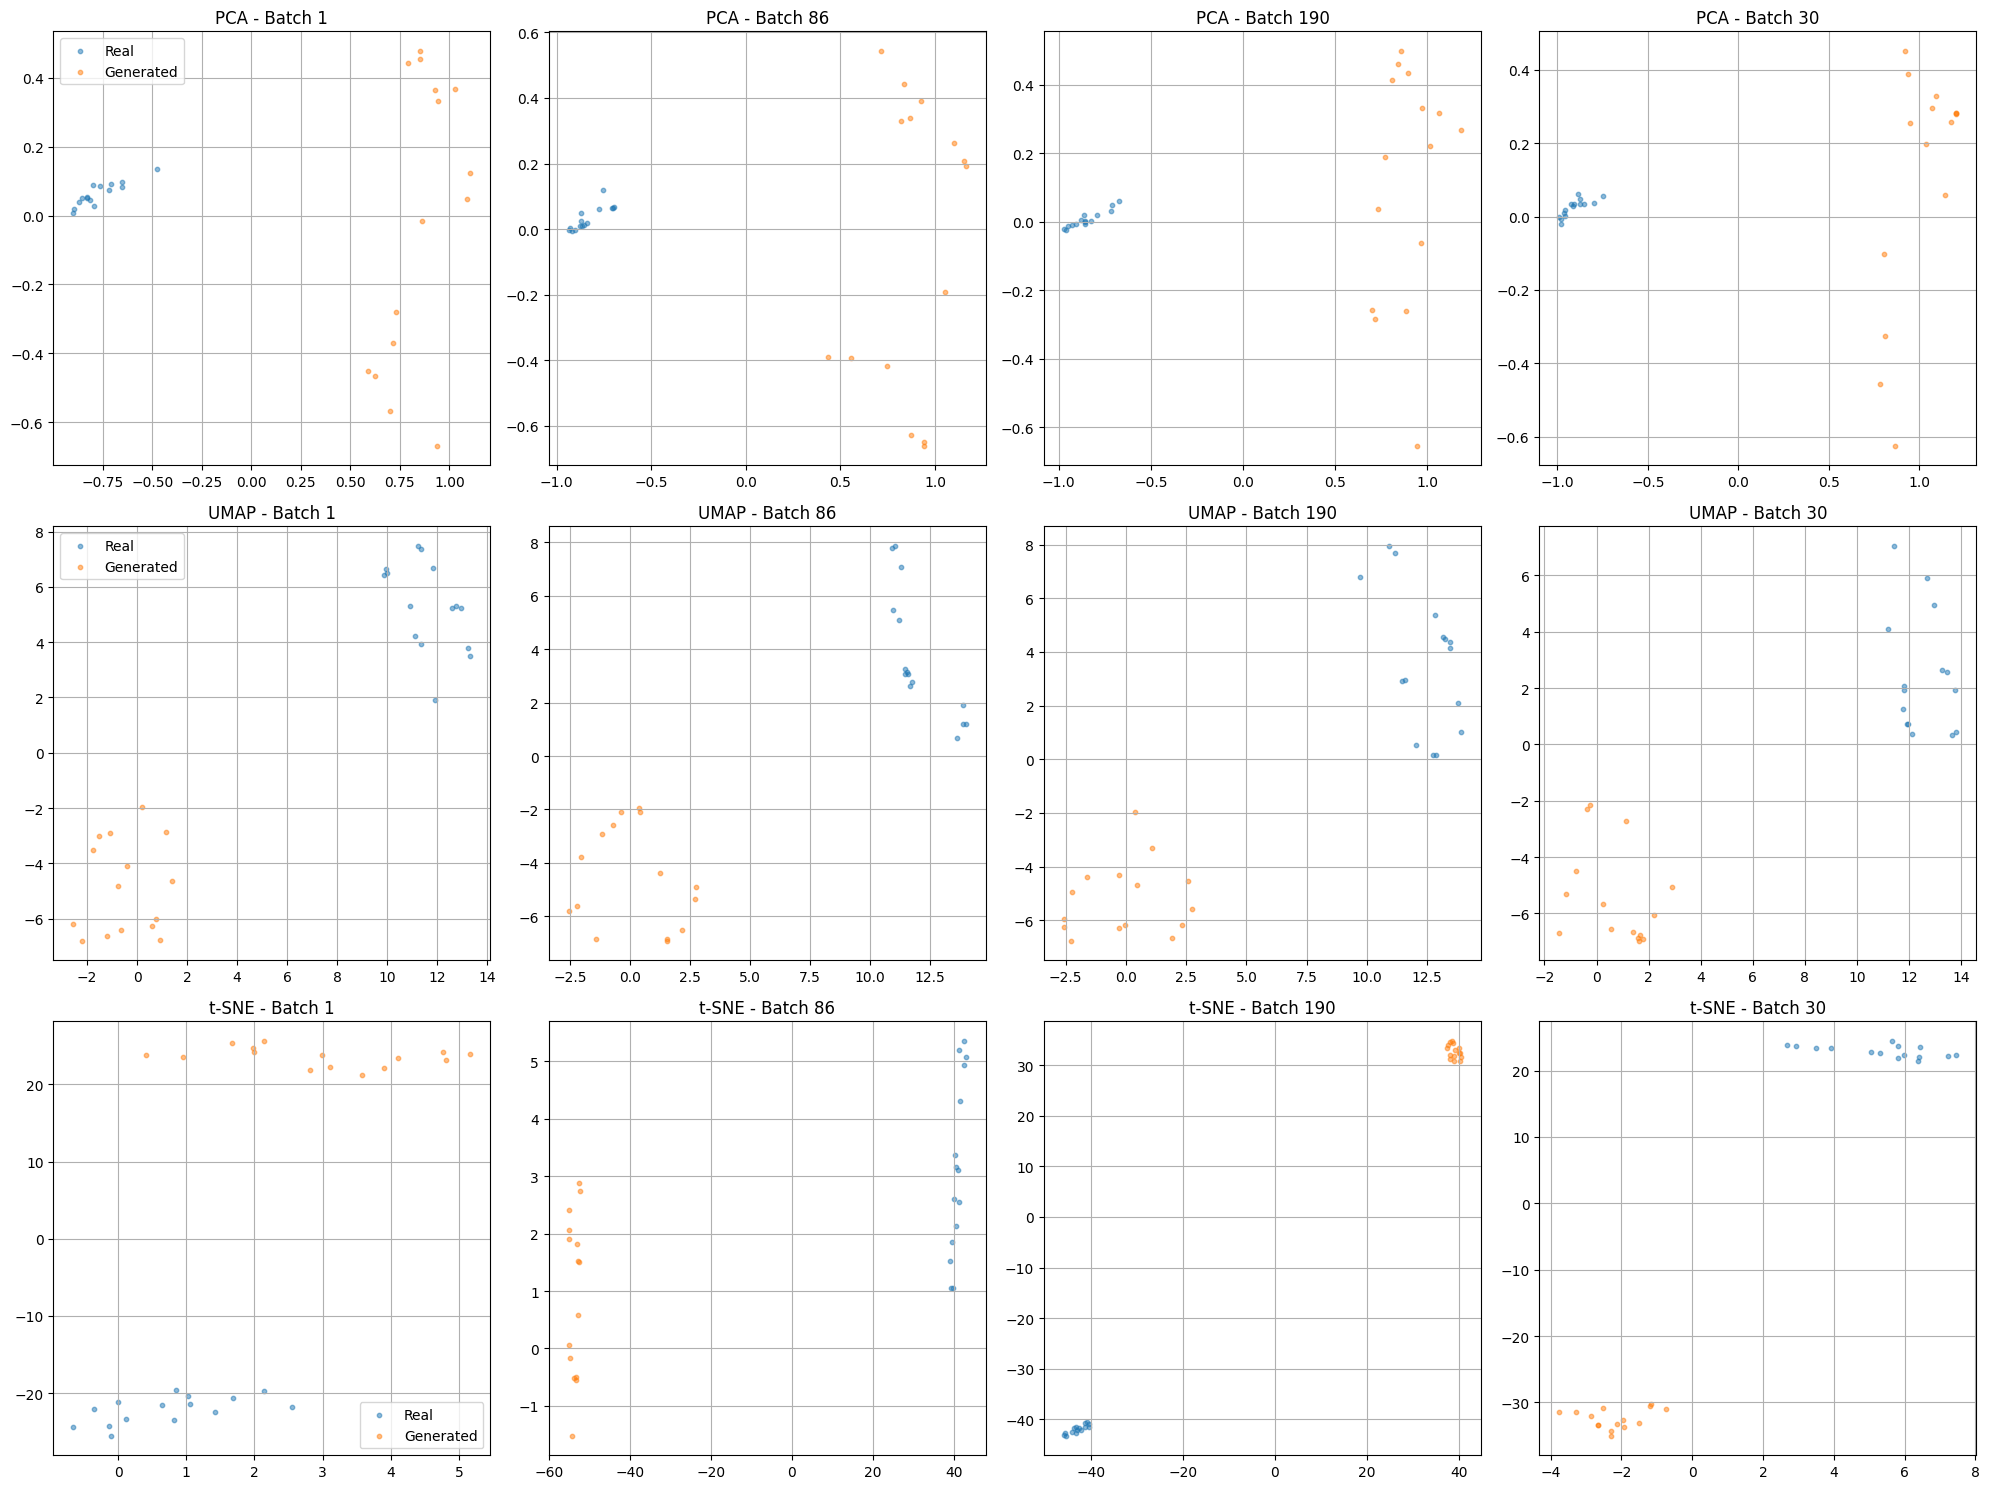

In [30]:
vizual_comparison(samples, real_data_test, os.path.join(logging_dir, "viz/", "pca_umap_tsne_per_batch.png"));

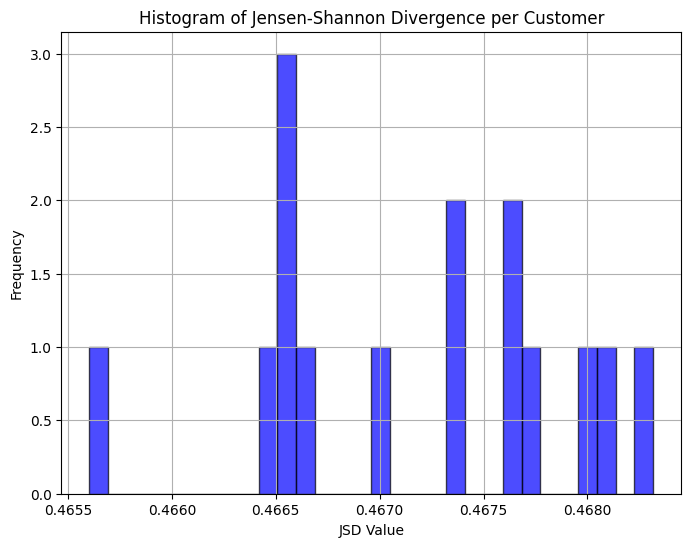

In [31]:
plot_jsd_per_customer(samples, real_data_test, os.path.join(logging_dir, "jsd/", "jsd.png"))

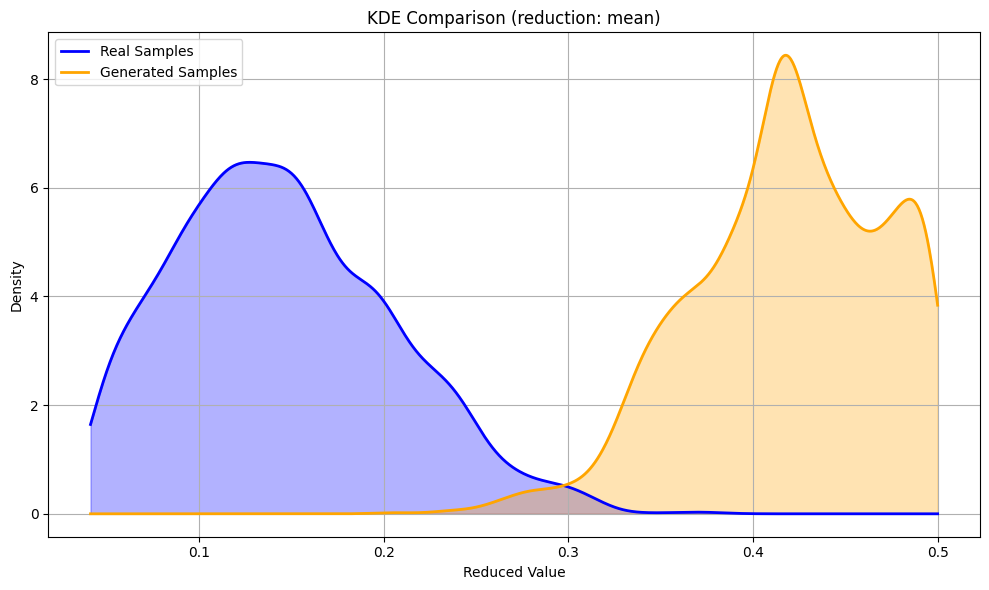

In [32]:
plot_kde_samples(samples, real_data_test, fpath=os.path.join(logging_dir, "kde/", f"kde.png"))

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\torch\nn\modules\rnn.py:1123: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:1410.)
  result = _VF.lstm(
sampling loop time step: 100%|██████████| 1000/1000 [00:10<00:00, 91.12it/s]


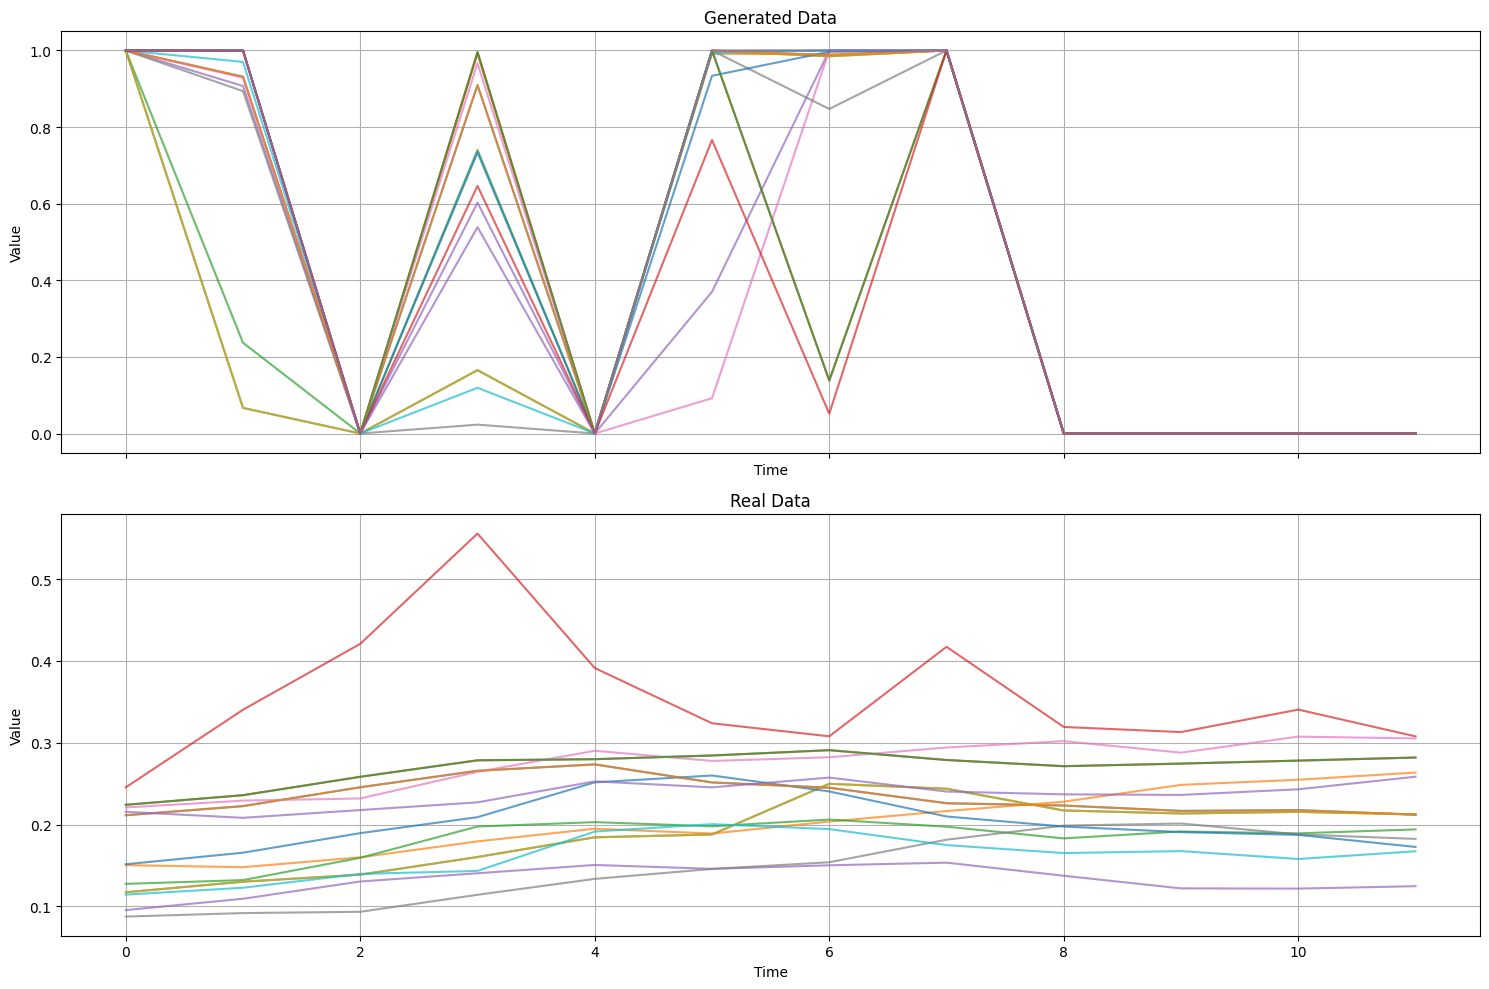

In [33]:
batch_idx = np.random.randint(0, 256) 
customer_indices = np.random.randint(0, 15, size=15)
fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

with torch.no_grad():
    sample = ddpm.sample(1, real_cond_data_test.to(device)) 
    sample = sample.cpu().numpy() 

for i in customer_indices:
    axs[0].plot(sample[0, i], alpha=0.7, label=f'Customer {i}')
    axs[1].plot(real_data_test[0, i], alpha=0.7, label=f'Customer {i}')

axs[0].set_title("Generated Data")
axs[1].set_title("Real Data")

for ax in axs:
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    ax.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(logging_dir, "ts_sample/", "samples.png"))
plt.show()